In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.io import loadmat
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from collections import Counter
from sklearn.model_selection import train_test_split

carregando os dados

In [ ]:
def load_radar_data(csv_file, radar_column='unit1_radar', label_column='unit1_beam_index'):
    # Especifique o diretório do seu drive (por exemplo, "/content/drive/MyDrive/Arquivos UFC") abaixo
    root_dir = '/content/drive/MyDrive/Arquivos UFC'

    csv_file = pd.read_csv(os.path.join(root_dir, csv_file))

    # Inicializa uma lista para armazenar os dados de radar
    X = []

    for i in tqdm(range(len(csv_file))):
        if i >= 1000:
            break  # Sai do loop após ler os primeiros 3000 arquivos
        try:
            # Tenta carregar o arquivo de radar
            radar_data = loadmat(os.path.abspath(os.path.join(root_dir, csv_file[radar_column][i])))['data']
            X.append(radar_data)
        except FileNotFoundError:
            print(f"O arquivo {csv_file[radar_column][i]} não foi encontrado e será ignorado.")

    # Converte a lista de arrays em um único array
    X = np.array(X, dtype=X[0].dtype)

    y = np.array(csv_file[label_column])
    return X, y

In [ ]:
x,y = load_radar_data('/content/drive/MyDrive/Arquivos UFC/unit1/scenario9.csv')

 17%|█▋        | 1000/5964 [06:12<30:48,  2.68it/s]


In [ ]:
y_verdade= y[:1000]


In [ ]:
print(len(Counter(y_verdade)))

58


In [ ]:
print(y_verdade.shape)

(1000,)


In [ ]:
print(x.shape)

(1000, 4, 256, 128)


pre - processamento

In [ ]:
def range_velocity_map(data):
    size = list(data.shape)
    size[1] = 1
    new_data = np.zeros(tuple(size), dtype=np.float32)
    for i in tqdm(range(data.shape[0])):
        new_data[i, 0, :, :] = range_velocity_map_single(data[i])
    return new_data


def range_velocity_map_single(data):
    data = np.fft.fft(data, axis=1) # Range FFT
    data = np.fft.fft(data, axis=2) # Velocity FFT
    data = np.abs(data).sum(axis=0) # Sum over antennas
    return data

100%|██████████| 1000/1000 [00:06<00:00, 162.00it/s]


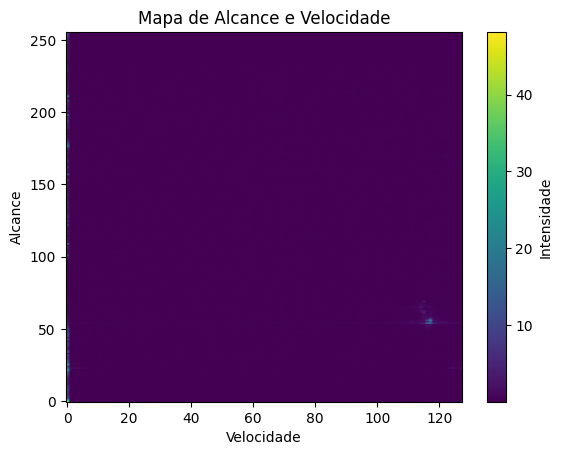

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_range_velocity_map(data):
    plt.imshow(data[0, 0, :, :], cmap='viridis', aspect='auto', origin='lower')
    plt.title('Mapa de Alcance e Velocidade')
    plt.xlabel('Velocidade')
    plt.ylabel('Alcance')
    plt.colorbar(label='Intensidade')
    plt.show()

# Supondo que você tenha um array de dados chamado 'dados'
dados_processados = range_velocity_map(x)

# Plotando o mapa de alcance e velocidade
plot_range_velocity_map(dados_processados)

# Salvando a figura
plt.savefig('mapa_alcance_velocidade.png')

In [ ]:
def range_angle_map(data, fft_size=64):
    size = list(data.shape)
    size[1] = 1
    size[3] = fft_size
    new_data = np.zeros(tuple(size), dtype=np.float32)
    for i in tqdm(range(data.shape[0])):
        new_data[i, 0, :, :] = range_angle_map_single(data[i], fft_size).T
    return new_data


def range_angle_map_single(data, fft_size = 64):
    data = np.fft.fft(data, axis=1) # Range FFT
    data -= np.mean(data, axis=2, keepdims=True)
    data = np.fft.fft(data, n=fft_size, axis=0) # Angle FFT
    data = np.abs(data).sum(axis=2) # Sum over velocity
    return data

100%|██████████| 1000/1000 [01:35<00:00, 10.49it/s]


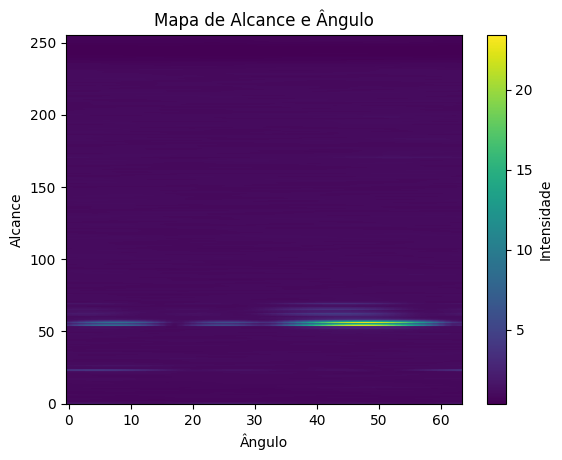

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_range_angle_map(data):
    plt.imshow(data[0, 0, :, :], cmap='viridis', aspect='auto', origin='lower')
    plt.title('Mapa de Alcance e Ângulo')
    plt.xlabel('Ângulo')
    plt.ylabel('Alcance')
    plt.colorbar(label='Intensidade')
    plt.show()

# Supondo que você tenha um array de dados chamado 'dados'
dados_processados = range_angle_map(x)

# Plotando o mapa de alcance e ângulo
plot_range_angle_map(dados_processados)

# Salvando a figura
plt.savefig('mapa_alcance_angulo.png')

In [ ]:
def radar_cube(data, fft_size=4):
    size = list(data.shape)
    size[1] = fft_size
    new_data = np.zeros(tuple(size), dtype=np.float32)
    for i in tqdm(range(data.shape[0])):
        new_data[i, :, :, :] = radar_cube_single(data[i], fft_size)
    return new_data

def radar_cube_single(data, fft_size = 4):
    data = np.fft.fft(data, axis=1) # Range FFT
    data = np.fft.fft(data, axis=2) # Velocity FFT
    data = np.fft.fft(data, n=fft_size, axis=0) # Angle FFT
    data = np.abs(data)
    return data

In [ ]:
velocidade = range_velocity_map(x)

100%|██████████| 1000/1000 [00:08<00:00, 115.79it/s]


In [ ]:
print(velocidade.shape)

(1000, 1, 256, 128)


In [ ]:
angle = range_angle_map(x)

100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


In [ ]:
print(angle.shape)

(1000, 1, 256, 64)


In [ ]:
cubo = radar_cube(x)

100%|██████████| 1000/1000 [00:10<00:00, 93.69it/s]


In [ ]:
print(cubo.shape)

(1000, 4, 256, 128)


In [ ]:
# Criar um conjunto de valores únicos
valores_unicos = set(y_verdade)

# Criar um dicionário mapeando cada valor único para um índice
indice_por_valor = {valor: indice for indice, valor in enumerate(valores_unicos)}

# Criar uma matriz one-hot
matriz_one_hot = np.zeros((len(y_verdade), len(valores_unicos)))

for i, valor in enumerate(y_verdade):
    matriz_one_hot[i, indice_por_valor[valor]] = 1

# Exibir a matriz one-hot
print(matriz_one_hot)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(matriz_one_hot.shape)

(1000, 58)


In [ ]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(velocidade, matriz_one_hot, test_size=0.2, random_state=42)

In [ ]:

model = Sequential()

model.add(BatchNormalization(input_shape=( 1,256, 128)))

model.add(Conv2D(36, (1, 3) ,
                 padding="valid",
                 activation='tanh',
                 input_shape=( 1, 256, 128)))

model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(16, (1, 3) ,
                 padding="valid",
                 activation='relu',
                 input_shape=( 1, 256, 128)))

model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(8, (1, 3) ,
                 padding="valid",
                 activation='tanh',
                 input_shape=( 1, 256, 128)))

model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(58, activation ='softmax'))

opt = Adam(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history1 = model.fit(X_treinamento, y_treinamento, epochs=100, validation_data=(X_teste, y_teste))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Bat  (None, 1, 256, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 254, 36)        13860     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 1, 127, 36)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 1, 125, 16)        1744      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 1, 62, 16)         0         
 ng2D)                                                           
                                                      

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
history_dict = history1.history
df = pd.DataFrame(history_dict)
df.to_csv('historico_treinamento_veloct.csv', index=False)

In [ ]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(angle, matriz_one_hot, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=( 1,256, 64)))
model.add(Conv2D(8, (1, 3) , padding="valid",activation='tanh', input_shape=( 1, 256, 64)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(8, (1, 3) , padding="valid",activation='relu', input_shape=( 1, 256, 64)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(4, (1, 3) , padding="valid",activation='tanh', input_shape=( 1, 256, 64)))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(58, activation ='softmax'))

opt = Adam(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history2= model.fit(X_treinamento, y_treinamento, epochs=100, validation_data=(X_teste, y_teste))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_11 (Ba  (None, 1, 256, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_33 (Conv2D)          (None, 1, 254, 8)         1544      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 1, 127, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 1, 125, 8)         200       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 1, 62, 8)          0         
 ng2D)                                                           
                                                     

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
history_dict = history2.history
df = pd.DataFrame(history_dict)
df.to_csv('historico_treinamento_angle.csv', index=False)

In [ ]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(cubo, matriz_one_hot, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=( 4,256, 128)))
model.add(Conv2D(8, (1, 3) , padding="valid",activation='tanh', input_shape=( 4, 256, 128)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(8, (1, 3) , padding="valid",activation='relu', input_shape=( 4, 256, 128)))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Conv2D(4, (1, 3) , padding="valid",activation='tanh', input_shape=( 4, 256, 128)))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(58, activation ='softmax'))

opt = Adam(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history3 = model.fit(X_treinamento, y_treinamento, epochs=100, validation_data=(X_teste, y_teste))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_13 (Ba  (None, 4, 256, 128)       512       
 tchNormalization)                                               
                                                                 
 conv2d_39 (Conv2D)          (None, 4, 254, 8)         3080      
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 4, 127, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 4, 125, 8)         200       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 4, 62, 8)          0         
 ng2D)                                                           
                                                     

In [ ]:
history_dict = history3.history
df = pd.DataFrame(history_dict)
df.to_csv('historico_treinamento_cubo.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dados CSV
df1 = pd.read_csv('/content/historico_treinamento_veloct.csv')
df2 = pd.read_csv('/content/historico_treinamento_angle.csv')
df3 = pd.read_csv('/content/historico_treinamento_cubo.csv')

In [ ]:
print(df1)

        loss  accuracy  val_loss  val_accuracy
0   5.767112   0.08250  4.695186         0.010
1   3.569374   0.14250  5.028607         0.010
2   3.303169   0.15625  4.306566         0.030
3   3.157487   0.16750  4.528365         0.020
4   3.101665   0.15750  3.267322         0.110
..       ...       ...       ...           ...
95  2.889637   0.24250  3.230577         0.175
96  2.890700   0.23875  3.142821         0.175
97  2.836680   0.23500  3.155170         0.180
98  2.827711   0.24875  3.037002         0.215
99  2.850228   0.23750  3.084560         0.180

[100 rows x 4 columns]


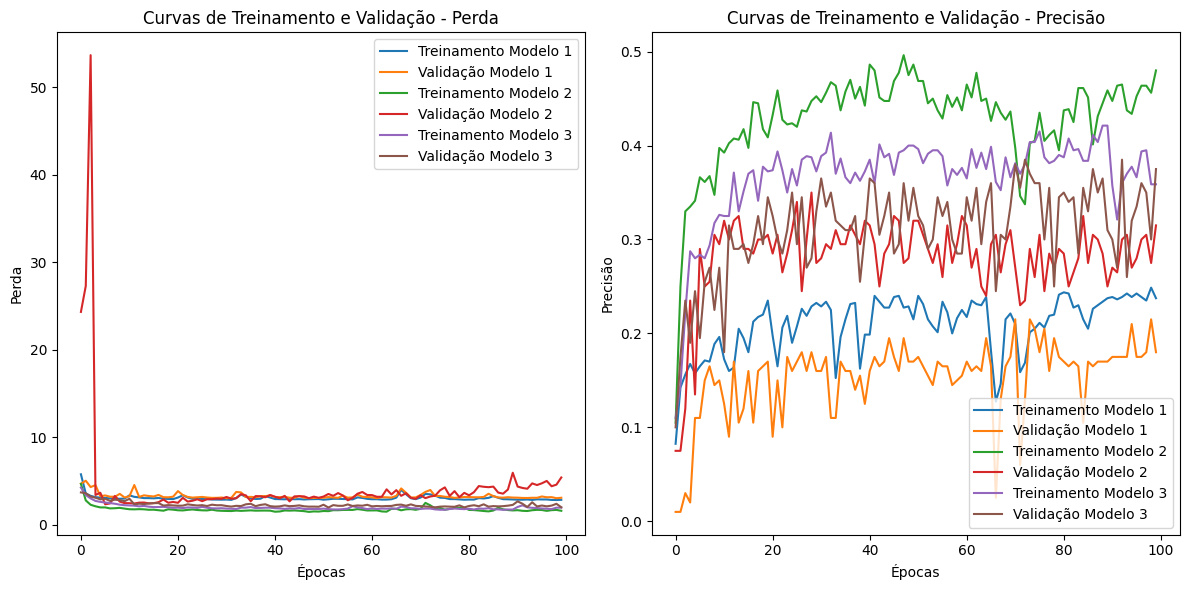

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dados CSV
df1 = pd.read_csv('/content/historico_treinamento_veloct.csv')
df2 = pd.read_csv('/content/historico_treinamento_angle.csv')
df3 = pd.read_csv('/content/historico_treinamento_cubo.csv')

# Plotar curvas de treinamento e validação para a perda
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot para a perda
plt.plot( df1['loss'], label='Treinamento Modelo 1')
plt.plot( df1['val_loss'], label='Validação Modelo 1')
plt.plot(df2['loss'], label='Treinamento Modelo 2')
plt.plot(df2['val_loss'], label='Validação Modelo 2')
plt.plot( df3['loss'], label='Treinamento Modelo 3')
plt.plot( df3['val_loss'], label='Validação Modelo 3')

plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Curvas de Treinamento e Validação - Perda')
plt.legend()

# Plotar curvas de treinamento e validação para uma métrica de avaliação (por exemplo, accuracy)
plt.subplot(1, 2, 2)  # Subplot para a métrica de avaliação
plt.plot( df1['accuracy'], label='Treinamento Modelo 1')
plt.plot( df1['val_accuracy'], label='Validação Modelo 1')
plt.plot( df2['accuracy'], label='Treinamento Modelo 2')
plt.plot( df2['val_accuracy'], label='Validação Modelo 2')
plt.plot( df3['accuracy'], label='Treinamento Modelo 3')
plt.plot( df3['val_accuracy'], label='Validação Modelo 3')

plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.title('Curvas de Treinamento e Validação - Precisão')
plt.legend()

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

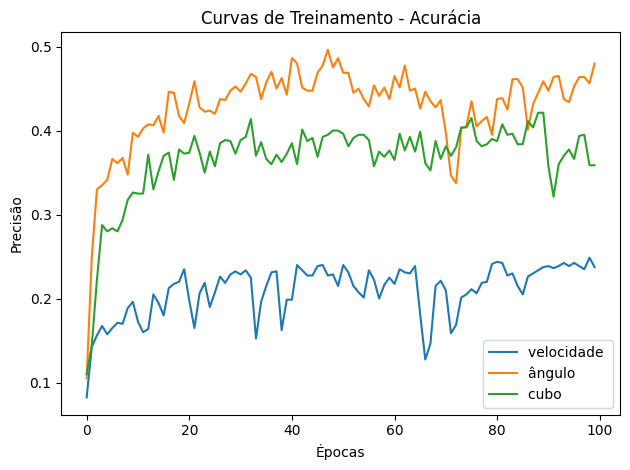

In [ ]:
# Plotar curvas de treinamento para a precisão


plt.subplot(1, 1, 1)  # Subplot para treinamento
plt.plot(df1.index, df1['accuracy'], label='velocidade ')
plt.plot(df2.index, df2['accuracy'], label='ângulo ')
plt.plot(df3.index, df3['accuracy'], label='cubo ')

plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.title('Curvas de Treinamento - Acurácia')
plt.legend(loc='lower right')  # Posiciona a legenda no canto inferior direito

# Ajustar layout
plt.tight_layout()

plt.savefig('comparaçao_modelos.png')

# Exibir os gráficos
plt.show()

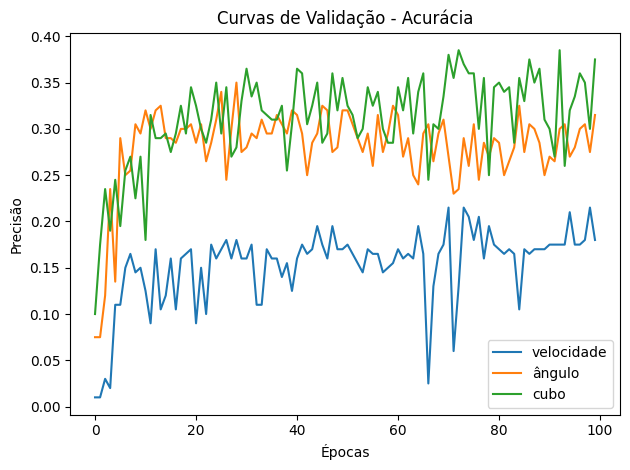

In [ ]:
# Subplot para validação
plt.subplot(1, 1, 1)  # Subplot para validação
plt.plot(df1.index, df1['val_accuracy'], label='velocidade')
plt.plot(df2.index, df2['val_accuracy'], label='ângulo')
plt.plot(df3.index, df3['val_accuracy'], label='cubo')

plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.title('Curvas de Validação - Acurácia')
plt.legend()

# Ajustar layout
plt.tight_layout()

plt.savefig('comparaçao_modelos_validação.png')

# Exibir os gráficos
plt.show()